In [1]:
import sagemaker
from sagemaker.mxnet import MXNet
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
import boto3
import os

sagemaker_session = sagemaker.Session()
BUCKET_NAME = sagemaker_session.default_bucket()
LOCATION_IN_BUCKET = 'smdebug-mnist-tensor-analysis'

s3_bucket_for_tensors = 's3://{BUCKET_NAME}/{LOCATION_IN_BUCKET}'.format(BUCKET_NAME=BUCKET_NAME, LOCATION_IN_BUCKET=LOCATION_IN_BUCKET)
estimator = MXNet(role=sagemaker.get_execution_role(),
                  base_job_name='mxnet',
                  train_instance_count=1,
                  train_instance_type='ml.m5.xlarge',
                  train_volume_size=400,
                  entry_point='mnist.py',
                  framework_version='1.6.0',
                  py_version='py3',
                  debugger_hook_config = DebuggerHookConfig(
                      s3_output_path=s3_bucket_for_tensors,  
                      collection_configs=[
                        CollectionConfig(
                            name="all",
                            parameters={
                                "include_regex": ".*",
                                "save_interval": "100"
                            }
                        )
                     ]
                   )
                )

In [2]:
estimator.fit(wait=False)

In [3]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

In [4]:
path = estimator.latest_job_debugger_artifacts_path()
print('Tensors are stored in: ', path)

Tensors are stored in:  s3://sagemaker-us-west-2-283429445338/smdebug-mnist-tensor-analysis/mxnet-2020-02-19-18-50-08-845/debug-output


In [5]:
job_name = estimator.latest_training_job.name
print('Training job name: {}'.format(job_name))

client = estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=job_name)

Training job name: mxnet-2020-02-19-18-50-08-845


In [6]:
import time
import numpy as np

def check_step_duration(trial):
    
    loaded_all_steps = False
    last_step = None
    start = time.time()
    step_durations = []
    
    while not loaded_all_steps:
        
        loaded_all_steps = trial.loaded_all_steps
        step = trial.steps()[-1]
        step_duration = time.time() - start
        
        if last_step != step:
            print("Time for step", step, "to become available", step_duration)
            last_step = step
            start = time.time()
            step_durations.append(step_duration) 
            
        elif len(step_durations) > 3 and step_duration > np.mean(step_durations) * 3:
            print("Time for step", step, "to become available taking too long. Stop the training job.")
            break
            
    return step_durations

In [7]:
import time
from smdebug.trials import create_trial

if description['TrainingJobStatus'] != 'Completed':
    while description['SecondaryStatus'] not in {'Training', 'Completed'}:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description['TrainingJobStatus']
        secondary_status = description['SecondaryStatus']
        print('Current job status: [PrimaryStatus: {}, SecondaryStatus: {}]'.format(primary_status, secondary_status))
        time.sleep(15)
        
trial = create_trial(path)

step_durations = check_step_duration(trial)

Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Starting]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Starting]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Starting]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Starting]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Starting]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Starting]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Starting]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Starting]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Downloading]
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Training]
[2020-02-19 18:52:40.200 ip-172-16-21-52:20080 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-283429445338/smdebug-mnist-tensor-analysis/mxnet-2020-02-19-18-50-08-845/debug-output
Time for step 0 to become availab

[2020-02-19 18:59:11.343 ip-172-16-21-52:20080 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-02-19 18:59:12.371 ip-172-16-21-52:20080 INFO trial.py:210] Loaded all steps


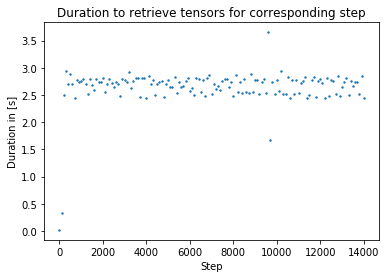

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Duration to retrieve tensors for corresponding step')
plt.xlabel('Step')
plt.ylabel('Duration in [s]')
plt.scatter(trial.steps(), step_durations, s=2)
plt.show()